Import Libraries

In [1]:
import jax
import flax
import optax
from jax import lax, random, numpy as jnp
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax import config
from flax import linen as nn
!pip install evojax
from evojax.util import get_params_format_fn

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
jax.config.update("jax_enable_x64", True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.7/269.7 kB 10.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
input_dir = "/content/drive/My Drive/DNN + Helmholtz/"

Mounted at /content/drive


Problem: 2D Helmholtz Equation

        (u_xx + u_yy) + k**2 * u = g

In [3]:
# Function to generate analytical solution
@jit
def eval_u(x, y, a1, a2):
    u = jnp.sin(a1*jnp.pi*x) * jnp.sin(a2*jnp.pi*y)
    return u

# obtain g
@jit
def eval_g(x, y, a1, a2):
    g = (k**2 - (a1*jnp.pi)**2 - (a2*jnp.pi)**2) * jnp.sin(a1*jnp.pi*x) * jnp.sin(a2*jnp.pi*y)
    return g

x_l, x_u = -1, 1
y_l, y_u = -1, 1

# PDE parameters
k = 1
a1, a2 = jnp.meshgrid(jnp.linspace(0, 6, 11)[1:], jnp.linspace(0, 6, 11)[1:])
a1, a2 = a1.reshape(-1, 1), a2.reshape(-1, 1)
task_params = jnp.hstack([a1, a2])
n_task = len(task_params)
print (n_task)
# a1 ∈ (0, 6] and a2 ∈ (0, 6]

100


In [4]:
# sample (64x64)
xs = jnp.linspace(-1, 1, 64)
ys = jnp.linspace(-1, 1, 64)
x, y = jnp.meshgrid(xs, ys)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
inputs = jnp.hstack([x, y])

#### Noiseless source function: analytical

k = 1.0, a1 = 1.2, a2 = 5.4


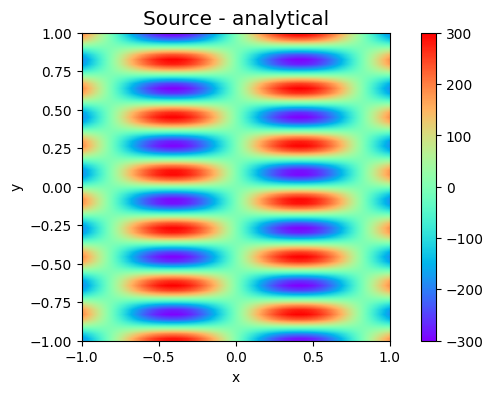

In [5]:
## example (noiseless source function: eval_g)
task = 81

#ground truth: a1 = 1.2, a2 = 5.4
a1, a2 = task_params[task]
g = eval_g(x, y, a1, a2)
print ('k = %.1f, a1 = %.1f, a2 = %.1f'%(k, a1, a2))

# plot
fig = plt.figure(figsize=(8, 4))
ext = [x_l, x_u, y_l, y_u]     # plot boundary
u_plot = g.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y');
plt.title('Source - analytical', fontsize='x-large');

#### Noisy data (inverse inference DNN)

In [6]:
class DNN(nn.Module):
    """DNN"""
    def setup(self):
        self.layers = [nn.Dense(n_nodes, kernel_init = jax.nn.initializers.he_uniform()),
                       jnp.sin]
        self.last_layer = nn.Dense(1, kernel_init = jax.nn.initializers.he_uniform(), use_bias=False)

    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        x, y = inputs[:,0:1], inputs[:,1:2]
        def get_u(x, y):
            f = jnp.hstack([x, y])
            for i, lyr in enumerate(self.layers):
                f = lyr(f)
                if (i == 0):
                    f = 4 *jnp.pi *f
            u = self.last_layer(f)
            return u

        u = get_u(x, y)

        outputs = u
        return outputs

In [7]:
# choose seed
seed = 8
key, rng = random.split(random.PRNGKey(seed))

# dummy input
a = random.normal(key, [1,2])

# initialization call
n_nodes = 1024
model_inv = DNN()
params_inv = model_inv.init(key, a)
num_params_inv, format_params_fn_inv = get_params_format_fn(params_inv)

# load weigths
params_inv = jnp.load(input_dir + 'InverseDNN_weights.npy')

In [8]:
# noisy source function
g_inv = model_inv.apply(format_params_fn_inv(params_inv), inputs) #use this data for symbolic regression?
#inputs from -1 to 1 (print inputs)

mse = jnp.mean(jnp.square(g_inv - g))
rl2 = jnp.linalg.norm(g_inv - g) / jnp.linalg.norm(g)
print ('Inference source mse = %.3f,  rl2 = %.3f'%(mse, rl2))

Inference source mse = 14.433,  rl2 = 0.027


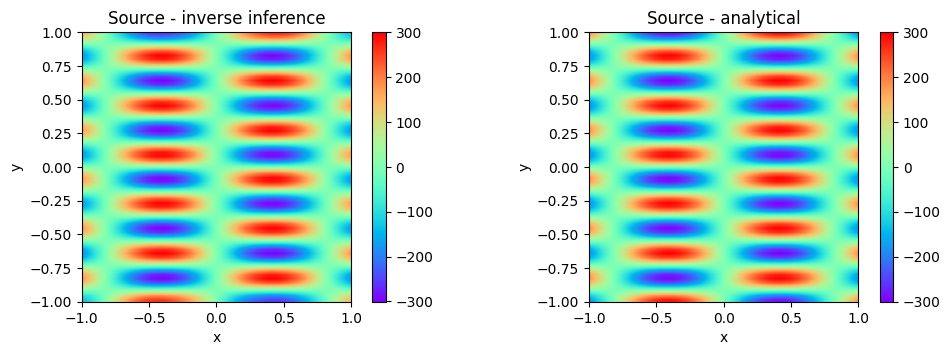

In [9]:
# plot
fig = plt.figure(figsize=(12, 3.5))
ax1 = fig.add_subplot(1,2,1)
u_plot = g_inv.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - inverse inference', fontsize='large');
ax1 = fig.add_subplot(1,2,2)
u_plot = g.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - analytical', fontsize='large');

# AI Feynman

In [ ]:
# Checking OS version, fortran compiler version, and granting relevant permissions (github only)
!sudo apt-get install csh
!lsb_release -a
!gfortran --version
!chmod +777 '/content/drive/My Drive/DNN + Helmholtz/'*

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
csh is already the newest version (20110502-7).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy
GNU Fortran (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Installing AI Feynman 2.0, c shell, and relevant packages
## https://ai-feynman.readthedocs.io/en/latest/
!pip install aifeynman --no-deps
!pip install sortedcontainers scikit-learn torch seaborn torchvision openpyxl

In [ ]:
import os
import aifeynman
from aifeynman import S_brute_force, S_run_aifeynman

In [ ]:
#Verify working directory
input_path = '/content/drive/My Drive/DNN + Helmholtz/'
os.chdir(input_path)
!pwd

/content/drive/My Drive/DNN + Helmholtz


In [ ]:
#check how inputs (x, y) look like
inputs

Array([[-1.        , -1.        ],
       [-0.96825397, -1.        ],
       [-0.93650794, -1.        ],
       ...,
       [ 0.93650794,  1.        ],
       [ 0.96825397,  1.        ],
       [ 1.        ,  1.        ]], dtype=float64)

In [ ]:
#Create data
data = jnp.hstack([inputs, g_inv])
data.shape

(4096, 3)

In [ ]:
# Saving data as a .txt file in working directory for use by symbolic regression function
np.save(input_path + 'helmholtz_data.npy', data)
np.savetxt(input_path + 'helmholtz_data.txt',data,delimiter=' ')

# Printing out generated data with Pandas and plotting it with matplotlib
df=pd.read_csv(input_path + 'helmholtz_data.txt',sep=" ",header=None)
data = df.to_numpy()
print(data.shape) #can also load txt file this way - going to just use generated file from before

(4096, 3)


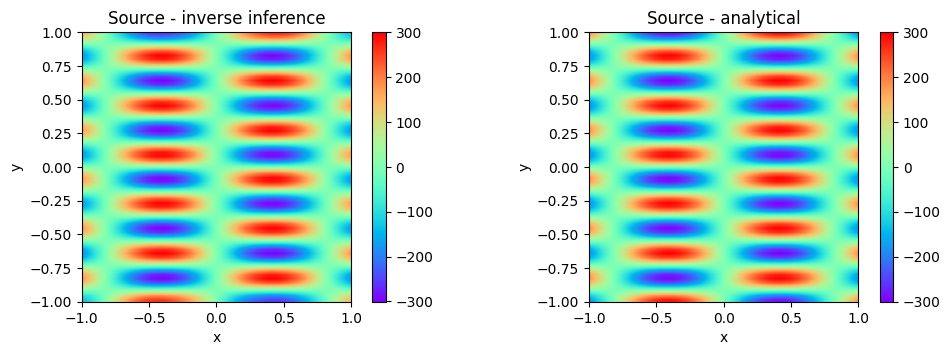

In [ ]:
#verify with a plot

fig = plt.figure(figsize=(12, 3.5))
ax1 = fig.add_subplot(1,2,1)
u_plot = data[:,2].reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - inverse inference', fontsize='large');
ax1 = fig.add_subplot(1,2,2)
u_plot = g.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - analytical', fontsize='large');

In [ ]:
#Running brute force test on perfect data
!pwd
S_brute_force.brute_force(input_path,"helmholtz_data.txt",30,"14ops.txt")

/content/drive/My Drive/DNN + Helmholtz
Trying to solve mysteries with brute force...
Trying to solve /content/drive/My Drive/DNN + Helmholtz/helmholtz_data.txt


In [ ]:
degrees = [3] #1, 2, 3
epochs = [4000] #, 600, 800
for degree in degrees:
    for num_epochs in epochs:
        print("Epochs:", num_epochs, "Degree", degree)
        # Printing out a few lines of data (purely for reference)
        !head -n 1 '/content/drive/My Drive/DNN + Helmholtz/helmholtz_data.txt'
        # Running symbolic regression function on generated dataset
        S_run_aifeynman.run_aifeynman(input_path,"helmholtz_data.txt",30,"14ops.txt", polyfit_deg=degrees, NN_epochs=epochs)

        # Viewing processed data
        !ls -1 '/content/drive/My Drive/DNN + Helmholtz/results'
        print("Result eq:")
        !cat '/content/drive/My Drive/DNN + Helmholtz/results/solution_helmholtz_data.txt'

Epochs: 4000 Degree 3
-1.000000000000000000e+00 -1.000000000000000000e+00 -1.303310296228398784e+02
Checking for brute force + 

Trying to solve mysteries with brute force...
Trying to solve /content/drive/My Drive/DNN + Helmholtz/helmholtz_data.txt_train
Checking for brute force * 

Trying to solve mysteries with brute force...
Trying to solve /content/drive/My Drive/DNN + Helmholtz/helmholtz_data.txt_train
Checking polyfit 

Pareto frontier in the current branch:

Complexity #  MDL Loss #  Expression
44.8 35.95 0.076334664556*pi
44.95 35.95 -0.084971487805*(-pi)
47.54 35.94 -0.025237362895+(x1*x1)
50.05 35.94 -0.432692283211+cos(cos(x0))
53.22 35.94 0.204843743285+cos(exp((x0+1)))
57.84 35.93 -10.074625680699+exp(exp(cos(x1)))
60.48 35.93 -0.641784362365*cos((x0*(pi+1)))
65.87 35.92 -53.798062826158+exp((pi+cos(x1)))

Checking for brute force + 

Trying to solve mysteries with brute force...
Trying to solve results/mystery_world_squared/helmholtz_data.txt_train
Checking for brute for

Plotting Result Functions

In [10]:
def eval_sr(x0, x1):

    # # eqn 1 - 200 deg 1,
    # u = jnp.sqrt(abs(666.000000000000*jnp.sin(((x0/x1)-((x0/x1)+jnp.pi))))) #had to add abs val

    # #eqn 2 - 400 deg 3
    # u = jnp.sqrt(abs(666.000000000000*(x1-(x1+jnp.sin(jnp.pi))))) #had to add abs val

    # #eqn 3 => this is just a static value? (degrees 1 400 iters)
    # u = 1/(666.000000000000+(jnp.pi/jnp.sin(jnp.pi)))

    # #eqn 4 - degree 1 400 iters, deg 2 400 iters
    # u = -0.015873015814*((jnp.sin(jnp.pi)/(x0/x1))-1)

    # #eqn 5 - degree 1 400 iters
    # u = jnp.sqrt(0.274376417234*jnp.cos((x0*jnp.sin(jnp.pi)))) #this is a constant

    # #eqn 6 - 200 deg 2
    # u = jnp.sqrt(0.242126480514*jnp.cos(((x0*x0))**(-1)))

    # #eqn 7 - 400 deg 2
    # u = jnp.tan(666.000000000000*(x0-(x0+jnp.sin(jnp.pi))))
    # u = -0.047619047619*((x0/x1)/jnp.sqrt(((x0/x1)*(x0/x1)))) #very weird
    # u = -0.047619047619*jnp.cos((jnp.pi/jnp.exp(jnp.exp((x0/x1)))))
    #u = jnp.sqrt(0.211892164273+(jnp.pi/jnp.exp((x0*x0)))) #parabolic surface
    #u = jnp.sqrt(0.242126480222+jnp.exp((x0-jnp.exp(jnp.exp(x0)))))
    #u = jnp.sqrt(0.242126480222*(jnp.exp(((x0/x1)-jnp.exp((x0/x1))))+1))
    #u = jnp.sqrt(0.242126480222+jnp.exp(((x0/x1)-jnp.exp(jnp.exp((x0/x1))))))
    #u = jnp.sqrt(0.113543037399*jnp.exp(((x0/x1)/jnp.log(jnp.exp((x0/x1))))))
    #u = jnp.sqrt(0.154320987654*(((x0/x1)/jnp.log(jnp.exp((x0/x1))))+1))

    #800 deg 2
    #u = jnp.asin(-666.000000000000*(x0-(x0+jnp.sin(jnp.pi))))
    #u = -0.015873015777*((jnp.sin(jnp.pi)/(x0/x1))+1)
    #u = -0.047619047619*((x0/x1)/jnp.sqrt(((x0/x1)*(x0/x1)))) #i think this appeared before
    #u = -0.047619047619*jnp.cos((jnp.pi/(jnp.exp((x0/x1))+1)))
    #u = -0.047619047619*jnp.cos((jnp.pi/jnp.exp(jnp.exp((x0/x1))))) #same with this
    #u = jnp.sqrt(0.242126480222+jnp.exp((x0-jnp.exp(jnp.exp(x0)))))
    #u = jnp.sqrt(0.242126480222*(jnp.exp(((x0/x1)-jnp.exp((x0/x1))))+1))
    #u = jnp.sqrt(0.242126480222+jnp.exp(((x0/x1)-jnp.exp(jnp.exp((x0/x1))))))
    #u = jnp.sqrt(0.242126480658*jnp.cos((x1/(x0*x0)))) #weird
    #u = jnp.sqrt(0.113543037399*jnp.exp(((x0/x1)/jnp.log(jnp.exp((x0/x1))))))
    #u = jnp.sqrt(0.154320987654*(((x0/x1)/jnp.log(jnp.exp((x0/x1))))+1)) #seems same as before


    #800 deg 3
    #u = jnp.sqrt(abs(666.000000000000*jnp.sin((x0-(x0+jnp.pi)))))
    #u = jnp.sqrt(abs(666.000000000000*jnp.sin(((x0/x1)-((x0/x1)+jnp.pi)))))

    #4000 epochs
    #u = jnp.tan(-0.146889952176*(x0/x1))
    u = jnp.atan(0.029650583827+(jnp.sin(jnp.pi)/(x0/x1)))

    return u

In [11]:
# sample (64x64)
xs = jnp.linspace(-1, 1, 64)
ys = jnp.linspace(-1, 1, 64)
x, y = jnp.meshgrid(xs, ys)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
inputs = jnp.hstack([x, y])
x_l, x_u = -1, 1
y_l, y_u = -1, 1
ext = [x_l, x_u, y_l, y_u]

soln = eval_sr(x, y) #inputs from earlier, should yield shape of (4096, 1)
soln.shape, soln

((4096, 1),
 Array([[0.0296419],
        [0.0296419],
        [0.0296419],
        ...,
        [0.0296419],
        [0.0296419],
        [0.0296419]], dtype=float64))

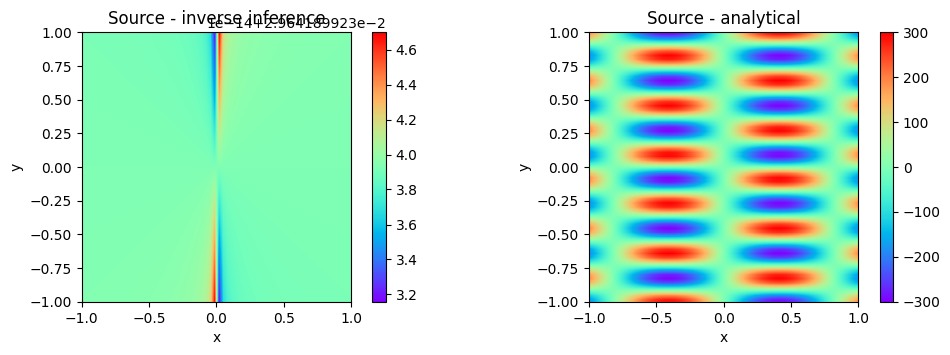

In [12]:
fig = plt.figure(figsize=(12, 3.5))
ax1 = fig.add_subplot(1,2,1)
u_plot = soln[:,2].reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - inverse inference', fontsize='large');
ax1 = fig.add_subplot(1,2,2)
u_plot = g.reshape(64, -1)
mesh2 = plt.imshow(u_plot, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1.);
plt.colorbar(mesh2);
plt.xlabel('x'); plt.ylabel('y'); plt.title('Source - analytical', fontsize='large');

In [ ]:
#MSE
mse = jnp.mean(jnp.square(soln - g))
rl2 = jnp.linalg.norm(soln - g) / jnp.linalg.norm(g)
print ('SR source mse = %.3f,  rl2 = %.3f'%(mse, rl2))

SR source mse = 14.388,  rl2 = 0.027


In [ ]:
mse = jnp.mean(jnp.square(soln - g_inv))
rl2 = jnp.linalg.norm(soln - g_inv) / jnp.linalg.norm(g_inv)
print ('SR source mse = %.3f,  rl2 = %.3f'%(mse, rl2))

SR source mse = 7.619,  rl2 = 0.020
